In [1]:
import argparse, os, math
import numpy as np
from scipy.stats import entropy

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
#[?]from torchvision.transforms import ToTensor

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

from tqdm.notebook import tqdm, trange

In [2]:
!nvidia-smi

Thu Jun 15 00:20:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   40C    P0    76W / 250W |      0MiB / 11178MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
n_epochs = 250
batch_size = 64
lr = 0.0002
b1, b2 = 0.5, 0.999
latent_dim = 100
img_size = 32
channels = 3
sample_interval = 400

In [4]:
cuda = True if torch.cuda.is_available() else False

In [5]:
cuda

True

In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


In [9]:
# adversarial loss
adv_loss = torch.nn.BCELoss()

In [10]:
g = Generator()
d = Discriminator()

In [11]:
if cuda:
    g.cuda()
    d.cuda()
    adv_loss.cuda()

In [12]:
g.apply(weights_init_normal)
d.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [13]:
transform = transforms.Compose(
    [transforms.Scale(32),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

# processing 4 images at once. *adjustable*
batch_size = 128

# set trainset: loading CIFAR-10, apply previously defined transform function
trainset = torchvision.datasets.CIFAR10(root = './data', 
                                        train = True, 
                                        #download = True, 
                                        transform = transform)

# set trainloader: put training dataset to DataLoader
dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)


/opt/conda/lib/python3.9/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [14]:
optimizer_G = torch.optim.Adam(g.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(d.parameters(), lr=lr, betas=(b1, b2))

In [15]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [16]:
device = torch.device('cuda')

In [17]:
from ignite.metrics import InceptionScore
from ignite.engine import Engine, Events

def eval_step(engine, batch):
    batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
    return batch


evaluator = Engine(eval_step)
inception_score = InceptionScore()
inception_score.attach(evaluator, "is")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /tmp/xdg-cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [19]:
is_history = []
g_loss_history = []
d_loss_history = []

for epoch in tqdm(range(n_epochs)):
    for i, (imgs, _) in tqdm(enumerate(dataloader)):

        # Adversarial ground truths
        valid = torch.ones((imgs.shape[0], 1), dtype=torch.float32, device=device)
        fake = torch.zeros((imgs.shape[0], 1), dtype=torch.float32, device=device)

        # Configure input
        real_imgs = imgs.type(Tensor)       
        
        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.from_numpy(np.random.normal(0, 1, (imgs.shape[0], latent_dim))).type(Tensor)

        # Generate a batch of images
        gen_imgs = g(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adv_loss(d(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adv_loss(d(real_imgs), valid)
        fake_loss = adv_loss(d(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            g_loss_history.append(g_loss.item())
            d_loss_history.append(d_loss.item())

    save_image(gen_imgs.data[:1], "cifar_dcgan_images/%d.png" % epoch, nrow=1, normalize=True)
    state = evaluator.run([gen_imgs.data])
    is_history.append(state.metrics["is"])
    print("Epoch %d, Inception Score: %f" % (epoch, state.metrics["is"]))


  0%|          | 0/250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0, Inception Score: 1.348868


0it [00:00, ?it/s]

Epoch 1, Inception Score: 1.341638


0it [00:00, ?it/s]

Epoch 2, Inception Score: 1.408219


0it [00:00, ?it/s]

Epoch 3, Inception Score: 1.280371


0it [00:00, ?it/s]

Epoch 4, Inception Score: 1.206213


0it [00:00, ?it/s]

Epoch 5, Inception Score: 1.392119


0it [00:00, ?it/s]

Epoch 6, Inception Score: 1.612663


0it [00:00, ?it/s]

Epoch 7, Inception Score: 1.409613


0it [00:00, ?it/s]

Epoch 8, Inception Score: 1.407462


0it [00:00, ?it/s]

Epoch 9, Inception Score: 1.518187


0it [00:00, ?it/s]

Epoch 10, Inception Score: 1.466186


0it [00:00, ?it/s]

Epoch 11, Inception Score: 1.311725


0it [00:00, ?it/s]

Epoch 12, Inception Score: 1.419791


0it [00:00, ?it/s]

Epoch 13, Inception Score: 1.523819


0it [00:00, ?it/s]

Epoch 14, Inception Score: 1.506907


0it [00:00, ?it/s]

Epoch 15, Inception Score: 1.616278


0it [00:00, ?it/s]

Epoch 16, Inception Score: 1.423908


0it [00:00, ?it/s]

Epoch 17, Inception Score: 1.515310


0it [00:00, ?it/s]

Epoch 18, Inception Score: 1.703613


0it [00:00, ?it/s]

Epoch 19, Inception Score: 1.537090


0it [00:00, ?it/s]

Epoch 20, Inception Score: 1.624693


0it [00:00, ?it/s]

Epoch 21, Inception Score: 1.411157


0it [00:00, ?it/s]

Epoch 22, Inception Score: 1.438377


0it [00:00, ?it/s]

Epoch 23, Inception Score: 1.633614


0it [00:00, ?it/s]

Epoch 24, Inception Score: 1.658370


0it [00:00, ?it/s]

Epoch 25, Inception Score: 1.578628


0it [00:00, ?it/s]

Epoch 26, Inception Score: 1.690193


0it [00:00, ?it/s]

Epoch 27, Inception Score: 1.523309


0it [00:00, ?it/s]

Epoch 28, Inception Score: 1.579771


0it [00:00, ?it/s]

Epoch 29, Inception Score: 1.631010


0it [00:00, ?it/s]

Epoch 30, Inception Score: 1.544656


0it [00:00, ?it/s]

Epoch 31, Inception Score: 1.665975


0it [00:00, ?it/s]

Epoch 32, Inception Score: 1.473028


0it [00:00, ?it/s]

Epoch 33, Inception Score: 1.594098


0it [00:00, ?it/s]

Epoch 34, Inception Score: 1.656953


0it [00:00, ?it/s]

Epoch 35, Inception Score: 1.687917


0it [00:00, ?it/s]

Epoch 36, Inception Score: 1.828158


0it [00:00, ?it/s]

Epoch 37, Inception Score: 1.646441


0it [00:00, ?it/s]

Epoch 38, Inception Score: 1.671212


0it [00:00, ?it/s]

Epoch 39, Inception Score: 1.840571


0it [00:00, ?it/s]

Epoch 40, Inception Score: 1.737008


0it [00:00, ?it/s]

Epoch 41, Inception Score: 1.626582


0it [00:00, ?it/s]

Epoch 42, Inception Score: 1.612293


0it [00:00, ?it/s]

Epoch 43, Inception Score: 1.759439


0it [00:00, ?it/s]

Epoch 44, Inception Score: 1.897062


0it [00:00, ?it/s]

Epoch 45, Inception Score: 1.643647


0it [00:00, ?it/s]

Epoch 46, Inception Score: 1.710862


0it [00:00, ?it/s]

Epoch 47, Inception Score: 1.952377


0it [00:00, ?it/s]

Epoch 48, Inception Score: 1.786218


0it [00:00, ?it/s]

Epoch 49, Inception Score: 1.928906


0it [00:00, ?it/s]

Epoch 50, Inception Score: 1.836676


0it [00:00, ?it/s]

Epoch 51, Inception Score: 2.157312


0it [00:00, ?it/s]

Epoch 52, Inception Score: 1.988450


0it [00:00, ?it/s]

Epoch 53, Inception Score: 1.935928


0it [00:00, ?it/s]

Epoch 54, Inception Score: 1.952076


0it [00:00, ?it/s]

Epoch 55, Inception Score: 1.873776


0it [00:00, ?it/s]

Epoch 56, Inception Score: 2.036019


0it [00:00, ?it/s]

Epoch 57, Inception Score: 2.126030


0it [00:00, ?it/s]

Epoch 58, Inception Score: 1.974248


0it [00:00, ?it/s]

Epoch 59, Inception Score: 1.901520


0it [00:00, ?it/s]

Epoch 60, Inception Score: 2.072282


0it [00:00, ?it/s]

Epoch 61, Inception Score: 2.049677


0it [00:00, ?it/s]

Epoch 62, Inception Score: 1.915950


0it [00:00, ?it/s]

Epoch 63, Inception Score: 2.037623


0it [00:00, ?it/s]

Epoch 64, Inception Score: 1.988552


0it [00:00, ?it/s]

Epoch 65, Inception Score: 1.895531


0it [00:00, ?it/s]

Epoch 66, Inception Score: 1.944554


0it [00:00, ?it/s]

Epoch 67, Inception Score: 2.417464


0it [00:00, ?it/s]

Epoch 68, Inception Score: 2.106216


0it [00:00, ?it/s]

Epoch 69, Inception Score: 2.095922


0it [00:00, ?it/s]

Epoch 70, Inception Score: 2.080618


0it [00:00, ?it/s]

Epoch 71, Inception Score: 2.086247


0it [00:00, ?it/s]

Epoch 72, Inception Score: 2.343019


0it [00:00, ?it/s]

Epoch 73, Inception Score: 2.406556


0it [00:00, ?it/s]

Epoch 74, Inception Score: 2.103356


0it [00:00, ?it/s]

Epoch 75, Inception Score: 2.058375


0it [00:00, ?it/s]

Epoch 76, Inception Score: 2.419769


0it [00:00, ?it/s]

Epoch 77, Inception Score: 2.274906


0it [00:00, ?it/s]

Epoch 78, Inception Score: 2.390806


0it [00:00, ?it/s]

Epoch 79, Inception Score: 2.447168


0it [00:00, ?it/s]

Epoch 80, Inception Score: 2.176308


0it [00:00, ?it/s]

Epoch 81, Inception Score: 2.116398


0it [00:00, ?it/s]

Epoch 82, Inception Score: 2.117654


0it [00:00, ?it/s]

Epoch 83, Inception Score: 2.507519


0it [00:00, ?it/s]

Epoch 84, Inception Score: 2.037870


0it [00:00, ?it/s]

Epoch 85, Inception Score: 2.111587


0it [00:00, ?it/s]

Epoch 86, Inception Score: 2.209703


0it [00:00, ?it/s]

Epoch 87, Inception Score: 2.245287


0it [00:00, ?it/s]

Epoch 88, Inception Score: 2.157482


0it [00:00, ?it/s]

Epoch 89, Inception Score: 2.048947


0it [00:00, ?it/s]

Epoch 90, Inception Score: 2.200622


0it [00:00, ?it/s]

Epoch 91, Inception Score: 2.455176


0it [00:00, ?it/s]

Epoch 92, Inception Score: 2.112803


0it [00:00, ?it/s]

Epoch 93, Inception Score: 2.165422


0it [00:00, ?it/s]

Epoch 94, Inception Score: 2.292194


0it [00:00, ?it/s]

Epoch 95, Inception Score: 2.204829


0it [00:00, ?it/s]

Epoch 96, Inception Score: 2.450446


0it [00:00, ?it/s]

Epoch 97, Inception Score: 2.266224


0it [00:00, ?it/s]

Epoch 98, Inception Score: 2.165235


0it [00:00, ?it/s]

Epoch 99, Inception Score: 2.388884


0it [00:00, ?it/s]

Epoch 100, Inception Score: 2.189067


0it [00:00, ?it/s]

Epoch 101, Inception Score: 2.225112


0it [00:00, ?it/s]

Epoch 102, Inception Score: 2.178434


0it [00:00, ?it/s]

Epoch 103, Inception Score: 2.329352


0it [00:00, ?it/s]

Epoch 104, Inception Score: 2.433253


0it [00:00, ?it/s]

Epoch 105, Inception Score: 1.916017


0it [00:00, ?it/s]

Epoch 106, Inception Score: 2.247532


0it [00:00, ?it/s]

Epoch 107, Inception Score: 2.319426


0it [00:00, ?it/s]

Epoch 108, Inception Score: 2.211484


0it [00:00, ?it/s]

Epoch 109, Inception Score: 2.497344


0it [00:00, ?it/s]

Epoch 110, Inception Score: 2.604722


0it [00:00, ?it/s]

Epoch 111, Inception Score: 2.362397


0it [00:00, ?it/s]

Epoch 112, Inception Score: 2.142478


0it [00:00, ?it/s]

Epoch 113, Inception Score: 2.370531


0it [00:00, ?it/s]

Epoch 114, Inception Score: 2.068071


0it [00:00, ?it/s]

Epoch 115, Inception Score: 2.175879


0it [00:00, ?it/s]

Epoch 116, Inception Score: 1.981964


0it [00:00, ?it/s]

Epoch 117, Inception Score: 2.270952


0it [00:00, ?it/s]

Epoch 118, Inception Score: 2.373674


0it [00:00, ?it/s]

Epoch 119, Inception Score: 2.297916


0it [00:00, ?it/s]

Epoch 120, Inception Score: 2.541676


0it [00:00, ?it/s]

Epoch 121, Inception Score: 2.201109


0it [00:00, ?it/s]

Epoch 122, Inception Score: 2.171140


0it [00:00, ?it/s]

Epoch 123, Inception Score: 2.074040


0it [00:00, ?it/s]

Epoch 124, Inception Score: 2.375225


0it [00:00, ?it/s]

Epoch 125, Inception Score: 2.292710


0it [00:00, ?it/s]

Epoch 126, Inception Score: 2.311198


0it [00:00, ?it/s]

Epoch 127, Inception Score: 2.156549


0it [00:00, ?it/s]

Epoch 128, Inception Score: 2.452805


0it [00:00, ?it/s]

Epoch 129, Inception Score: 2.400572


0it [00:00, ?it/s]

Epoch 130, Inception Score: 2.472449


0it [00:00, ?it/s]

Epoch 131, Inception Score: 2.191791


0it [00:00, ?it/s]

Epoch 132, Inception Score: 2.523452


0it [00:00, ?it/s]

Epoch 133, Inception Score: 2.043076


0it [00:00, ?it/s]

Epoch 134, Inception Score: 2.337550


0it [00:00, ?it/s]

Epoch 135, Inception Score: 2.696688


0it [00:00, ?it/s]

Epoch 136, Inception Score: 2.412782


0it [00:00, ?it/s]

Epoch 137, Inception Score: 2.330442


0it [00:00, ?it/s]

Epoch 138, Inception Score: 2.664431


0it [00:00, ?it/s]

Epoch 139, Inception Score: 2.105924


0it [00:00, ?it/s]

Epoch 140, Inception Score: 2.299596


0it [00:00, ?it/s]

Epoch 141, Inception Score: 2.788537


0it [00:00, ?it/s]

Epoch 142, Inception Score: 2.468210


0it [00:00, ?it/s]

Epoch 143, Inception Score: 2.428136


0it [00:00, ?it/s]

Epoch 144, Inception Score: 2.227199


0it [00:00, ?it/s]

Epoch 145, Inception Score: 2.758925


0it [00:00, ?it/s]

Epoch 146, Inception Score: 2.641040


0it [00:00, ?it/s]

Epoch 147, Inception Score: 2.255497


0it [00:00, ?it/s]

Epoch 148, Inception Score: 2.173382


0it [00:00, ?it/s]

Epoch 149, Inception Score: 2.335134


0it [00:00, ?it/s]

Epoch 150, Inception Score: 2.330555


0it [00:00, ?it/s]

Epoch 151, Inception Score: 2.660849


0it [00:00, ?it/s]

Epoch 152, Inception Score: 2.721666


0it [00:00, ?it/s]

Epoch 153, Inception Score: 2.302552


0it [00:00, ?it/s]

Epoch 154, Inception Score: 2.443487


0it [00:00, ?it/s]

Epoch 155, Inception Score: 2.227372


0it [00:00, ?it/s]

Epoch 156, Inception Score: 2.338787


0it [00:00, ?it/s]

Epoch 157, Inception Score: 2.506216


0it [00:00, ?it/s]

Epoch 158, Inception Score: 2.339002


0it [00:00, ?it/s]

Epoch 159, Inception Score: 2.195276


0it [00:00, ?it/s]

Epoch 160, Inception Score: 2.368049


0it [00:00, ?it/s]

Epoch 161, Inception Score: 2.257131


0it [00:00, ?it/s]

Epoch 162, Inception Score: 2.629497


0it [00:00, ?it/s]

Epoch 163, Inception Score: 2.559858


0it [00:00, ?it/s]

Epoch 164, Inception Score: 2.541985


0it [00:00, ?it/s]

Epoch 165, Inception Score: 2.566078


0it [00:00, ?it/s]

Epoch 166, Inception Score: 2.175881


0it [00:00, ?it/s]

Epoch 167, Inception Score: 2.572888


0it [00:00, ?it/s]

Epoch 168, Inception Score: 2.397151


0it [00:00, ?it/s]

Epoch 169, Inception Score: 2.429620


0it [00:00, ?it/s]

Epoch 170, Inception Score: 2.772286


0it [00:00, ?it/s]

Epoch 171, Inception Score: 2.485693


0it [00:00, ?it/s]

Epoch 172, Inception Score: 3.011378


0it [00:00, ?it/s]

Epoch 173, Inception Score: 2.391014


0it [00:00, ?it/s]

Epoch 174, Inception Score: 2.714134


0it [00:00, ?it/s]

Epoch 175, Inception Score: 2.094310


0it [00:00, ?it/s]

Epoch 176, Inception Score: 2.365513


0it [00:00, ?it/s]

Epoch 177, Inception Score: 2.572924


0it [00:00, ?it/s]

Epoch 178, Inception Score: 2.337178


0it [00:00, ?it/s]

Epoch 179, Inception Score: 2.460683


0it [00:00, ?it/s]

Epoch 180, Inception Score: 2.779086


0it [00:00, ?it/s]

Epoch 181, Inception Score: 2.336302


0it [00:00, ?it/s]

Epoch 182, Inception Score: 2.509862


0it [00:00, ?it/s]

Epoch 183, Inception Score: 2.484567


0it [00:00, ?it/s]

Epoch 184, Inception Score: 2.592699


0it [00:00, ?it/s]

Epoch 185, Inception Score: 2.520026


0it [00:00, ?it/s]

Epoch 186, Inception Score: 2.626284


0it [00:00, ?it/s]

Epoch 187, Inception Score: 2.439941


0it [00:00, ?it/s]

Epoch 188, Inception Score: 2.622561


0it [00:00, ?it/s]

Epoch 189, Inception Score: 2.382274


0it [00:00, ?it/s]

Epoch 190, Inception Score: 2.536668


0it [00:00, ?it/s]

Epoch 191, Inception Score: 2.700691


0it [00:00, ?it/s]

Epoch 192, Inception Score: 2.687677


0it [00:00, ?it/s]

Epoch 193, Inception Score: 2.423220


0it [00:00, ?it/s]

Epoch 194, Inception Score: 2.442613


0it [00:00, ?it/s]

Epoch 195, Inception Score: 2.546541


0it [00:00, ?it/s]

Epoch 196, Inception Score: 2.369578


0it [00:00, ?it/s]

Epoch 197, Inception Score: 2.292805


0it [00:00, ?it/s]

Epoch 198, Inception Score: 2.716796


0it [00:00, ?it/s]

Epoch 199, Inception Score: 2.325640


0it [00:00, ?it/s]

Epoch 200, Inception Score: 2.635578


0it [00:00, ?it/s]

Epoch 201, Inception Score: 2.587377


0it [00:00, ?it/s]

Epoch 202, Inception Score: 2.675699


0it [00:00, ?it/s]

Epoch 203, Inception Score: 2.763292


0it [00:00, ?it/s]

Epoch 204, Inception Score: 2.403634


0it [00:00, ?it/s]

Epoch 205, Inception Score: 2.882298


0it [00:00, ?it/s]

Epoch 206, Inception Score: 2.391297


0it [00:00, ?it/s]

Epoch 207, Inception Score: 2.494775


0it [00:00, ?it/s]

Epoch 208, Inception Score: 2.481718


0it [00:00, ?it/s]

Epoch 209, Inception Score: 2.785853


0it [00:00, ?it/s]

Epoch 210, Inception Score: 2.491782


0it [00:00, ?it/s]

Epoch 211, Inception Score: 2.775261


0it [00:00, ?it/s]

Epoch 212, Inception Score: 2.944526


0it [00:00, ?it/s]

Epoch 213, Inception Score: 3.017409


0it [00:00, ?it/s]

Epoch 214, Inception Score: 2.664915


0it [00:00, ?it/s]

Epoch 215, Inception Score: 2.865517


0it [00:00, ?it/s]

Epoch 216, Inception Score: 2.819106


0it [00:00, ?it/s]

Epoch 217, Inception Score: 2.128345


0it [00:00, ?it/s]

Epoch 218, Inception Score: 2.519797


0it [00:00, ?it/s]

Epoch 219, Inception Score: 2.441647


0it [00:00, ?it/s]

Epoch 220, Inception Score: 2.354839


0it [00:00, ?it/s]

Epoch 221, Inception Score: 2.643256


0it [00:00, ?it/s]

Epoch 222, Inception Score: 2.565777


0it [00:00, ?it/s]

Epoch 223, Inception Score: 2.867967


0it [00:00, ?it/s]

Epoch 224, Inception Score: 2.857235


0it [00:00, ?it/s]

Epoch 225, Inception Score: 2.649979


0it [00:00, ?it/s]

Epoch 226, Inception Score: 2.761776


0it [00:00, ?it/s]

Epoch 227, Inception Score: 2.263788


0it [00:00, ?it/s]

Epoch 228, Inception Score: 2.734433


0it [00:00, ?it/s]

Epoch 229, Inception Score: 2.530625


0it [00:00, ?it/s]

Epoch 230, Inception Score: 2.757375


0it [00:00, ?it/s]

Epoch 231, Inception Score: 2.499538


0it [00:00, ?it/s]

Epoch 232, Inception Score: 2.576970


0it [00:00, ?it/s]

Epoch 233, Inception Score: 2.714900


0it [00:00, ?it/s]

Epoch 234, Inception Score: 2.918286


0it [00:00, ?it/s]

Epoch 235, Inception Score: 2.608240


0it [00:00, ?it/s]

Epoch 236, Inception Score: 2.349154


0it [00:00, ?it/s]

Epoch 237, Inception Score: 2.383179


0it [00:00, ?it/s]

Epoch 238, Inception Score: 2.650906


0it [00:00, ?it/s]

Epoch 239, Inception Score: 2.241913


0it [00:00, ?it/s]

Epoch 240, Inception Score: 2.527494


0it [00:00, ?it/s]

Epoch 241, Inception Score: 2.768016


0it [00:00, ?it/s]

Epoch 242, Inception Score: 2.496853


0it [00:00, ?it/s]

Epoch 243, Inception Score: 2.546078


0it [00:00, ?it/s]

Epoch 244, Inception Score: 2.858544


0it [00:00, ?it/s]

Epoch 245, Inception Score: 2.923797


0it [00:00, ?it/s]

Epoch 246, Inception Score: 2.307115


0it [00:00, ?it/s]

Epoch 247, Inception Score: 2.911588


0it [00:00, ?it/s]

Epoch 248, Inception Score: 2.422148


0it [00:00, ?it/s]

Epoch 249, Inception Score: 2.539439


In [24]:
torch.save({
            'epoch': epoch,
            'generator_state_dict': g.state_dict(),
            'discriminator_state_dict': d.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'loss_G': g_loss,
            'loss_D': d_loss,
            }, "trained_models/DCGAN_250_cifar-10.pth")

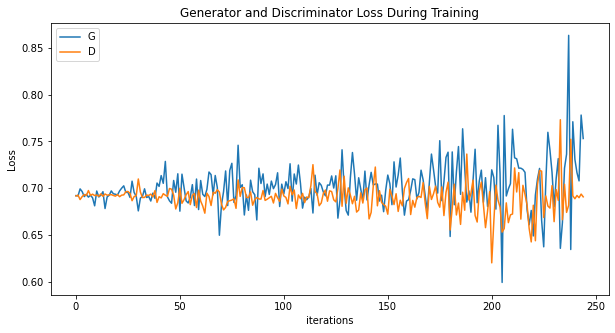

In [22]:
import matplotlib.pyplot as plt


# Plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_history,label="G")
plt.plot(d_loss_history,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


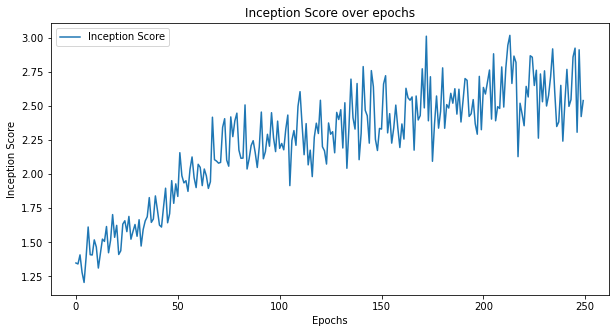

In [23]:
# IS history

plt.figure(figsize=(10,5))
plt.title("Inception Score over epochs")
plt.plot(is_history, label="Inception Score")
plt.xlabel("Epochs")
plt.ylabel("Inception Score")
plt.legend()
plt.show()

In [20]:
from cleanfid import fid

fdir1 = "cifar_dcgan_images"

cifar10_fid_score = fid.compute_fid(fdir1, dataset_name="cifar10", dataset_res = 32, dataset_split = "train")

compute FID of a folder with cifar10 statistics
Found 739 images in the folder cifar_dcgan_images


FID cifar_dcgan_images : 100%|██████████| 24/24 [00:04<00:00,  5.70it/s]


In [21]:
cifar10_fid_score

254.02029756412418